<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Tesis_redes_arbol_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Grafica fija.

V=['A','B','C','D','E']
E=[('A','B'),('B','C'),('B','D'),('C','E')]

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
G = nx.Graph()

In [5]:
G.add_nodes_from(V)

In [6]:
G.add_edges_from(E)

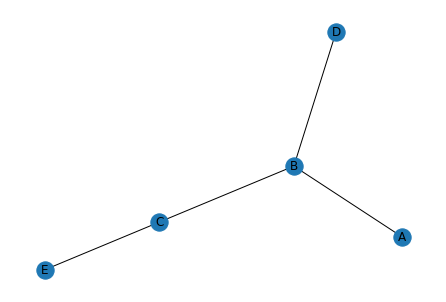

In [7]:
nx.draw(G,with_labels=True)
plt.draw()

In [8]:
for neigh in G.neighbors('C'):
    print(neigh)

B
E


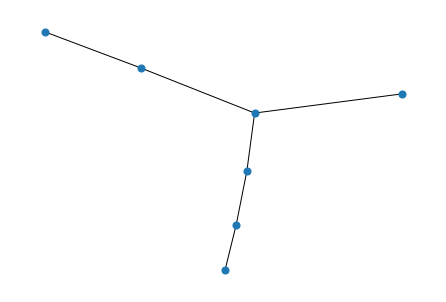

In [9]:
G_rand=nx.random_tree(7,)
nx.draw(G_rand,node_size=50)
plt.draw()

Podemos calcular antes de la simulación los tiempos de contacto y recuperación de cada individuo. Estos tiempos definen una red direccionada con pesos, y podemos conocer a cada instante el estado de la población considerada. 

Me gustaría hacer un código para ilustrar lo anterior. 

Sean $\beta$, $\gamma$ constantes y conocidas. 
Sea $N$ conocido el número de individuos en la población y sea $G=(V,E)$ la gráfica conexa de tipo arbol que modela su interacción. 

Obtenemos $(r_i)_{i=1}^N$ una sucesión de tiempos de recuperación para cada individuo. Es decir, una vez que se infecte (si es que lo hace), estará en el estado infecciosos durante $r_i$ unidades de tiempo. 

A su vez, para cada individuo $i$, denotando por $\mathcal{N}(i)$ al conjunto de nodos adyacentes a $i$, calculamos sus tiempos de contacto $(c_j^{(i)})_{j=1}^{\mathcal{N}(i)}$ con cada uno de sus vecinos. Es decir, cuando el individuo se infecta (si es que lo hace), sabemos que en $c_j^{(i)}$ unidades de tiempo tendrá un contacto con el individuo $j$, que podría o no ser susceptible. 

Cuando ocurre que $j$ es susceptible y que el tiempo de recuperación de $i$ es mayor que el tiempo de contacto con $j$, tenemos una infección en el individuo $j$ a través del contacto $(i,j)\in E$.

Supongamos que al inicio de la epidemia hay un único individuo infectado $i_0$, sabemos que el individuo $j$, el cual no necesariamente es adyacente a $i$ no puede ser susceptible al tiempo $t$ si ocurre una de las siguientes 2 posibilidades: 
$j$ es uno de los individuos infectados al tiempor $t=0$ o, 
Existe un camino de longitud menor que $t$ desde $j$ a un nodo infectado al tiempo $t=0$


Nota. Esto funciona bien por la propiedad de pérdida de memoria de la exponencial. Específicamente, cuando obtenemos los tiempos de contacto imediatamente después de una infección, estamos suponiendo que no importa el tiempo en el que se infecta el nodo, solo importa el tiempo que tarde antes del primer contacto.

In [23]:
import numpy as np
import scipy.stats 

In [66]:
beta=8/9
gamma=2/9

In [85]:
recuperation_times=np.random.exponential(scale=1/gamma,size=len(V))
contact_times=nx.to_numpy_matrix(G)
for i in range(contact_times.shape[0]):
    for j in range(i,contact_times.shape[1]):
        if(contact_times[i,j]!=0.):
            contact_times[i,j]=round(np.random.exponential(scale=1/beta),3)
print(recuperation_times)
print(contact_times)

[ 0.17038922  1.83937682  4.88813948  0.84752384 11.51492473]
[[0.    0.091 0.    0.    0.   ]
 [1.    0.    2.469 1.044 0.   ]
 [0.    1.    0.    0.    0.347]
 [0.    1.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.   ]]


In [86]:
G1=nx.from_numpy_matrix(contact_times.transpose())

Evolución en el tiempo.

Se puede considerar discretizado y graficar en cada tiempo de "cambio"

Asumimos el nodo 0 como el único inicialmente infectado.

In [114]:
p=nx.shortest_path_length(G1, source=0,weight='weight')
list(p.values())

[0, 0.091, 1.135, 2.56, 2.907]

In [160]:
T=list(p.values())
T

[0, 0.091, 1.135, 2.56, 2.907]

In [164]:
[2]

2.56

In [142]:
list(G1.nodes)

[0, 1, 2, 3, 4]

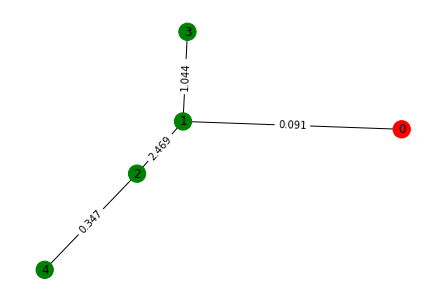

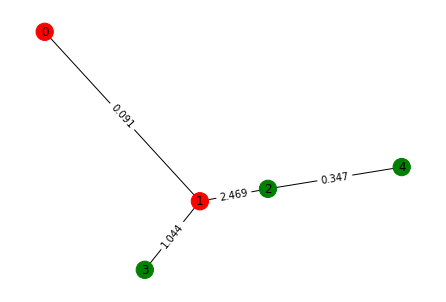

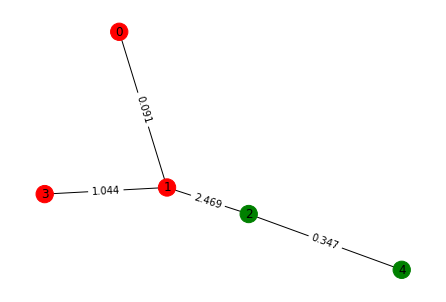

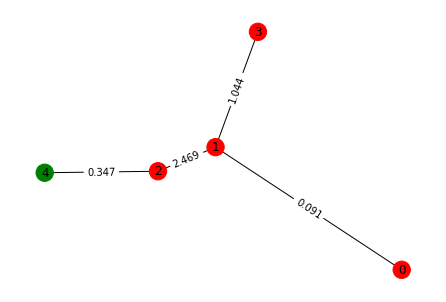

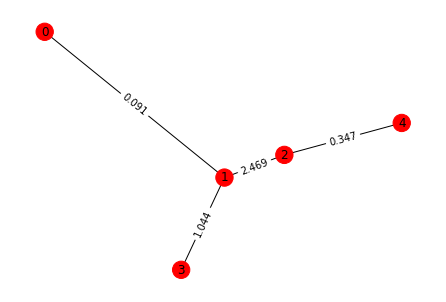

In [167]:
color_map_0=['red' if i==0 else 'green' for i in range(len(list(G1.nodes)))]
color_map=['red' if i==0 else 'green' for i in range(len(list(G1.nodes)))]
for t in T[0:]:

    for j in list(G1.nodes):
        if color_map_0[j]!='red' and nx.shortest_path_length(G1, source=0,weight='weight',)[j]<=t:
            color_map[j]='red'
    pos=nx.spring_layout(G1)
    labels = nx.get_edge_attributes(G1,'weight',)
    nx.draw(G1,pos, node_color=color_map, with_labels=True)
    nx.draw_networkx_edge_labels(G1,pos,edge_labels=labels)
    plt.draw()
    plt.show()

In [94]:
p

{0: 0, 1: 0.091, 3: 1.135, 2: 2.56, 4: 2.907}